<b> Project Description </b>

The project involves analyzing and modeling gold recovery data from three datasets:

   gold_recovery_train.csv: Training dataset<br>
   gold_recovery_test.csv: Test dataset<br>
   gold_recovery_full.csv: Source dataset with all features

<b> Objective: </b> Prepare the data, analyze it, and build a predictive model for gold recovery.

<b> Instructions: </b>
    
Prepare the Data:
     Open and inspect the datasets.<br>
     Verify the accuracy of recovery calculations in the training set.<br>
     Analyze the features not available in the test set, including their types.<br>
     Perform necessary data preprocessing.

<b> Analyze the Data: </b><br>
     Observe how metal concentrations change at different purification stages.<br>
     Compare feed particle size distributions between the training and test sets.<br>
     Evaluate the total concentrations at different stages for anomalies and address any issues.

<b> Build the Model: </b><br>
     Create a function to calculate the final sMAPE (symmetric Mean Absolute Percentage Error) value.<br>
     Train and evaluate various models using cross-validation. Select the best model and test it on the test sample.

<b> Evaluation Metrics: </b> Follow the provided formulas for calculating evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

from scipy.stats import iqr
from itertools import islice

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MaxAbsScaler, RobustScaler
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

<b> Explore Data </b>

In [3]:
try:
    df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

except:
    print('Something is wrong with your data')

In [4]:
df_full.info()
df_full.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


(22716, 87)

In [5]:
df_train.info()
df_train.shape
df_train.drop(columns='date', index=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
df_test.info()
df_test.shape
# df_test.drop(columns='date', index=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

(5856, 53)

In [7]:
print((df_full.duplicated().sum(), df_train.duplicated().sum(), df_test.duplicated().sum()))

(0, 16, 0)


In [8]:
df_full_nan = pd.DataFrame(data=[df_full.isna().sum().tolist(), ['{:.2f}'.format(i)+'%' \
           for i in (df_full.isna().sum()/df_full.shape[0]*100).tolist()]], 
           columns=df_full.columns, index=['NaN Count', 'NaN Percent']).transpose()

df_full_nan.style.background_gradient(cmap='Blues', subset=['NaN Count'])

,NaN Count,NaN Percent
date,0,0.00%
final.output.concentrate_ag,89,0.39%
final.output.concentrate_pb,87,0.38%
final.output.concentrate_sol,385,1.69%
final.output.concentrate_au,86,0.38%
final.output.recovery,1963,8.64%
final.output.tail_ag,83,0.37%
final.output.tail_pb,200,0.88%
final.output.tail_sol,271,1.19%
final.output.tail_au,81,0.36%


In [9]:
df_train_nan = pd.DataFrame(data=[df_train.isna().sum().tolist(), ['{:.2f}'.format(i)+'%' \
           for i in (df_train.isna().sum()/df_train.shape[0]*100).tolist()]], 
           columns=df_train.columns, index=['NaN Count', 'NaN Percent']).transpose()

df_train_nan.style.background_gradient(cmap='Oranges', subset=['NaN Count'])

,NaN Count,NaN Percent
final.output.concentrate_ag,72,0.43%
final.output.concentrate_pb,72,0.43%
final.output.concentrate_sol,370,2.19%
final.output.concentrate_au,71,0.42%
final.output.recovery,1521,9.02%
final.output.tail_ag,66,0.39%
final.output.tail_pb,183,1.09%
final.output.tail_sol,145,0.86%
final.output.tail_au,66,0.39%
primary_cleaner.input.sulfate,1307,7.75%


<b> Training set cleaning </b>

In [10]:
# NaN removal and Inf replacement in order to be able to calculate our recovery calculation and sMAPE correctly
## Data was already placed into Training and Test sets, dropping NaNs here should be okay and not spill over into data leakage territory
df_train.dropna(inplace=True)
df_train.replace([np.inf, -np.inf], 0, inplace=True)

In [11]:
df_test_nan = pd.DataFrame(data=[df_test.isna().sum().tolist(), ['{:.2f}'.format(i)+'%' \
           for i in (df_test.isna().sum()/df_test.shape[0]*100).tolist()]], 
           columns=df_test.columns, index=['NaN Count', 'NaN Percent']).transpose()

df_test_nan.style.background_gradient(cmap='Greens', subset=['NaN Count'])

,NaN Count,NaN Percent
date,0,0.00%
primary_cleaner.input.sulfate,302,5.16%
primary_cleaner.input.depressant,284,4.85%
primary_cleaner.input.feed_size,0,0.00%
primary_cleaner.input.xanthate,166,2.83%
primary_cleaner.state.floatbank8_a_air,16,0.27%
primary_cleaner.state.floatbank8_a_level,16,0.27%
primary_cleaner.state.floatbank8_b_air,16,0.27%
primary_cleaner.state.floatbank8_b_level,16,0.27%
primary_cleaner.state.floatbank8_c_air,16,0.27%


<b> Descriptive statistics </b>

In [12]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


In [13]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,...,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000
mean,5.156254,10.172706,9.600964,44.131766,66.807996,9.699026,2.661076,10.934617,3.009184,140.423475,...,19.305464,-476.379165,15.031783,-456.359652,16.460886,-481.893915,12.754424,-482.150528,20.127841,-508.577714
std,1.340526,1.589737,2.842133,4.171437,8.821443,2.335039,0.956443,2.736705,0.810098,36.240296,...,5.537726,52.792731,5.394614,60.329674,5.849667,40.614383,5.864024,41.887858,5.594330,39.611486
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.873963,...,4.502796,-799.709069,4.815717,-799.889113,-0.372054,-797.142475,3.145675,-800.006180,0.195324,-809.045795
25%,4.231049,9.279527,7.952263,43.244370,62.954521,7.944320,1.968099,9.359555,2.493010,114.760370,...,14.519944,-500.605493,10.121519,-500.158019,11.032620,-500.359690,8.045665,-500.110488,15.005303,-500.873732
50%,4.999101,10.347546,9.268938,44.802348,67.319200,9.525787,2.641639,10.789339,2.931333,138.955661,...,18.982882,-499.621459,14.055455,-498.772447,16.033894,-499.631737,11.969783,-499.897695,19.996901,-500.090380
75%,5.852602,11.187033,10.904984,46.092333,72.061074,11.162284,3.286537,12.070684,3.471886,164.759480,...,24.979838,-401.869808,20.033849,-399.939349,20.019224,-450.684310,16.677064,-450.145969,24.993169,-499.546117
max,16.001945,17.031899,18.124851,51.571885,100.000000,19.552149,5.639565,22.272019,7.812801,250.127834,...,30.115735,-245.239184,24.007913,-163.742242,43.709931,-275.073125,27.926001,-183.442252,32.188906,-104.427459


In [14]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


<b> Recovery Calculation </b>

<b> C: Share of Gold in Concentrate </b>

In [15]:
C = df_train['rougher.output.concentrate_au']
print('Null values:', C.isnull().sum())

Null values: 0


<b> F: Share of Gold in Feed </b>

In [16]:
F = df_train['rougher.input.feed_au']
print('Null values:', F.isnull().sum())

Null values: 0


<b> T: Share of Gold in Rougher Tails </b>

In [17]:
T = df_train['rougher.output.tail_au']
print('Null values:', T.isnull().sum())

Null values: 0


<b> Visualizing our Recovery Metrics </b>

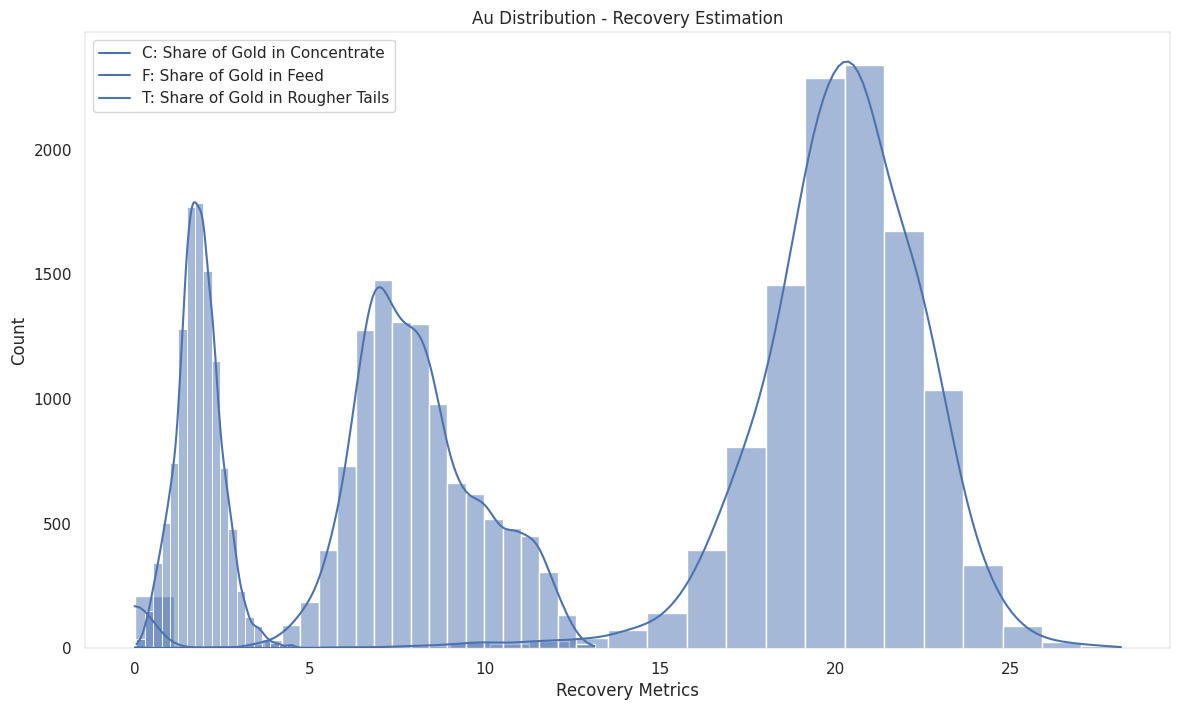

In [18]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(14, 8))
for r in [C, F, T]:
    sns.histplot(r, bins=25, ax=ax, kde=True).set_title('Au Distribution - Recovery Estimation')
    ax.set_xlabel('Recovery Metrics')
    ax.legend(labels=['C: Share of Gold in Concentrate','F: Share of Gold in Feed','T: Share of Gold in Rougher Tails'])

<b> Rougher Output Recovery </b>

In [19]:
recovery_calc = lambda df, C, F, T: ((df[C] * (df[F] - df[T])) \
                               / (df[F] * (df[C] - df[T])))  * 100

estimated_recovery = recovery_calc(df_train.dropna(subset=['rougher.output.recovery']), 
                                'rougher.output.concentrate_au',
                                'rougher.input.feed_au', 
                                'rougher.output.tail_au')

estimated_recovery = estimated_recovery.fillna(0)
estimated_recovery.replace([np.inf, -np.inf], 0, inplace=True)

#display(estimated_recovery.sort_values())

<b> Final Output Recovery </b>

In [20]:
final_estimated_recovery = recovery_calc(df_train.dropna(subset=['final.output.recovery']), 
                                'final.output.concentrate_au',
                                'rougher.input.feed_au',
                                'final.output.tail_au')

final_estimated_recovery = final_estimated_recovery.fillna(0) # filling in NaN with zero as final_error below has a mismatch after dropping NaN
final_estimated_recovery.replace([np.inf, -np.inf], 0, inplace=True)
#display(final_estimated_recovery.sort_values())

<b> Mean Absolute Error - Rougher </b>

In [21]:
recovery_feature = df_train['rougher.output.recovery']
print('Null values:', recovery_feature.isna().sum())

Null values: 0


In [22]:
error = mean_absolute_error(recovery_feature, estimated_recovery)

print("Mean absolute error:", error)
print(f"MAE with supression: {error:.17f}")

Mean absolute error: 9.45971292906466e-15
MAE with supression: 0.00000000000000946


<b> Mean Absolute Error - Final </b>

In [23]:
final_recovery_feature = df_train['final.output.recovery']
print('Null values:', final_recovery_feature.isna().sum())
#print('Null values:', final_recovery_feature.mean())

Null values: 0


In [24]:
final_error = mean_absolute_error(final_recovery_feature, final_estimated_recovery)

print("Mean absolute error : ", final_error)
print(f"MAE with supression: {final_error:.17f}")

Mean absolute error :  8.186141186364662e-15
MAE with supression: 0.00000000000000819


<b> Findings </b>

After removing NaN values, the average error between the predictions and actuals in this feature comparison (rougher recovery) is ~0.00000000000000946, which is a good value considering the average feature value is ~82.74 For final recovery, following the same process as prior and replacing infinity values, we see a slightly lower absolute error of ~0.00000000000000819 with the average final feature value of about 66.8 -- not a crazy MAE given the average value.

<b> Missing Features from Test dataset </b>

In [25]:
column_difference = df_train.columns.difference(df_test.columns)
display(pd.Series(column_difference))

0                           final.output.concentrate_ag
1                           final.output.concentrate_au
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_au
7                                  final.output.tail_pb
8                                 final.output.tail_sol
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_au
11                primary_cleaner.output.concentrate_pb
12               primary_cleaner.output.concentrate_sol
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_au
15                       primary_cleaner.output.tail_pb
16                      primary_cleaner.output.tail_sol
17                      rougher.calculation.au_p

<b> Findings </b>

The above is a list of features between the train and test datasets where the 34 columns displayed are all missing from the test dataset (all float types). These will be dropped from the Train dataset once we evaluate the chosen model and leverage the Test dataset.

Parameters include (with their respective types):

concentrate (outputs)

tail (outputs)

pb_ratio (calculation)

floatbank10_sulfate_to_au_feed & floatbank11_sulfate_to_au_feed (calculation)

sulfate_to_au_concentrate (calculation)

recovery (outputs)

<b> Concentration of Metals </b>

<b> Au </b>

In [26]:
# Base Concentrate
au_metal = df_train['rougher.output.concentrate_au']
# First Purification Stage (Concentrate)
first_purif_au = df_train['primary_cleaner.output.concentrate_au']
# Second Purification Stage (Tail - Residues)
second_purif_au = df_train['secondary_cleaner.output.tail_au']
# Final Output
final_output_au = df_train['final.output.concentrate_au']
# summary
dict_au = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au',
           'secondary_cleaner.output.tail_au', 'final.output.concentrate_au']
df_train[dict_au].agg(['mean', 'median', 'var', 'std'])

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,secondary_cleaner.output.tail_au,final.output.concentrate_au
mean,19.776763,32.380828,4.274828,44.131766
median,20.262513,33.016945,3.956963,44.802348
var,12.964445,28.393822,5.241296,17.400887
std,3.600617,5.328585,2.289388,4.171437


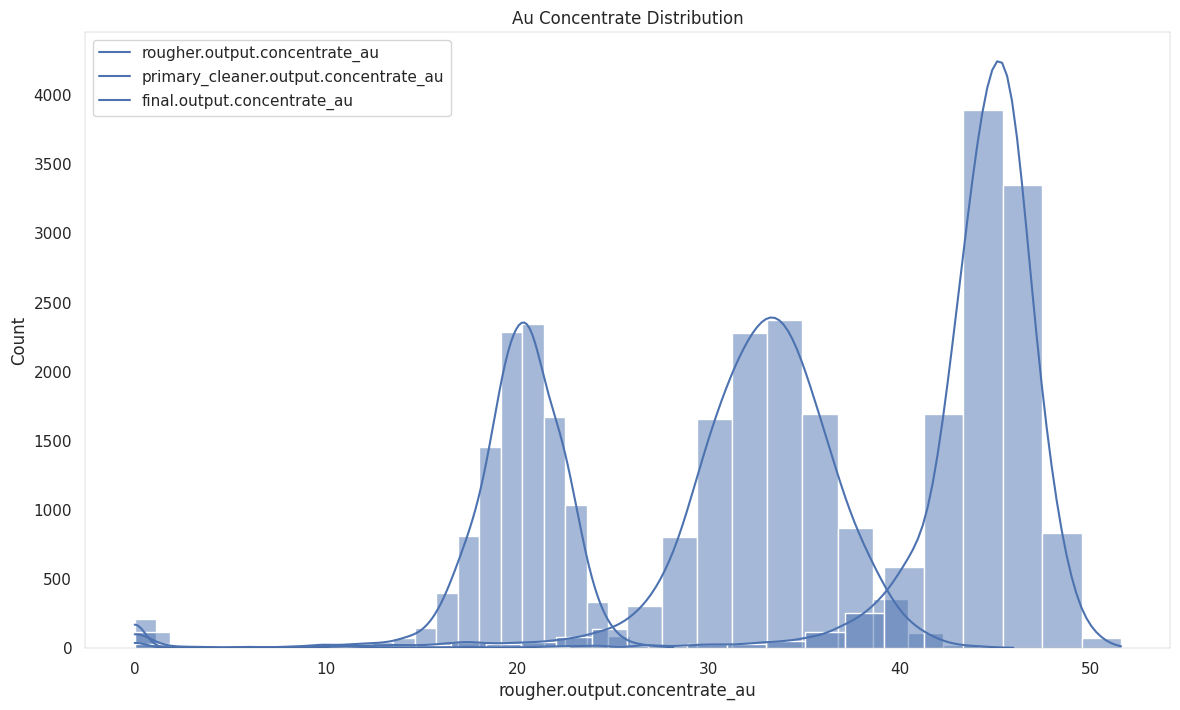

In [27]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(14, 8))
au_values = [au_metal, first_purif_au,final_output_au]
for r in au_values:
    sns.histplot(r, bins=25, ax=ax, kde=True).set_title('Au Concentrate Distribution')
    ax.legend(labels=['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au'])

<b> Ag </b>

In [28]:
# Base Concentrate
ag_metal = df_train['rougher.output.concentrate_ag']
# First Purification Stage (Concentrate)
first_purif_ag = df_train['primary_cleaner.output.concentrate_ag']
# Second Purification Stage (Tail - Residues)
second_purif_ag = df_train['secondary_cleaner.output.tail_ag']
# Final Output
final_output_ag = df_train['final.output.concentrate_ag']
# summary
dict_ag = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag',
           'secondary_cleaner.output.tail_ag', 'final.output.concentrate_ag']
df_train[dict_ag].agg(['mean', 'median', 'var', 'std'])

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,secondary_cleaner.output.tail_ag,final.output.concentrate_ag
mean,11.842002,8.437240,14.239971,5.156254
median,11.797862,8.436041,14.706733,4.999101
var,7.218432,3.567055,16.491916,1.797010
std,2.686714,1.888665,4.061024,1.340526


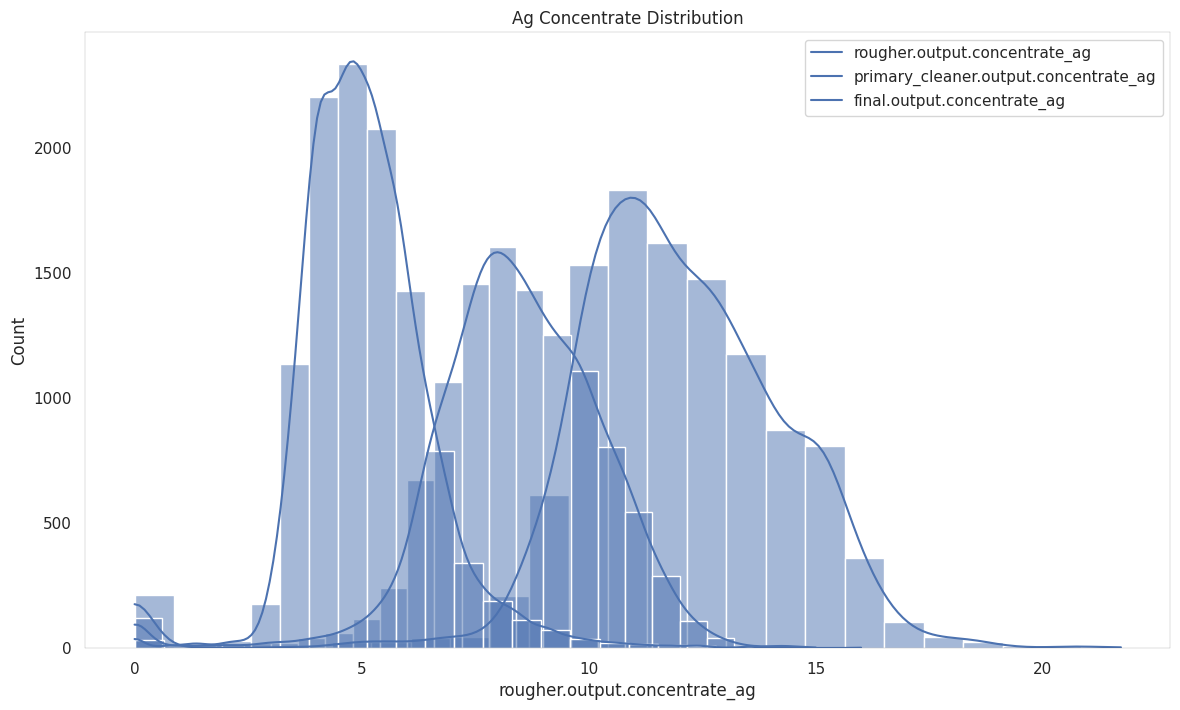

In [29]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(14, 8))
ag_values = [ag_metal, first_purif_ag,final_output_ag]
for r in ag_values:
    sns.histplot(r, bins=25, ax=ax, kde=True).set_title('Ag Concentrate Distribution')
    ax.legend(labels=['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag'])

<b> Pb </b>

In [30]:
# Base Concentrate
pb_metal = df_train['rougher.output.concentrate_pb']
# First Purification Stage (Concentrate)
first_purif_pb = df_train['primary_cleaner.output.concentrate_pb']
# Second Purification Stage (Tail - Residues)
second_purif_pb = df_train['secondary_cleaner.output.tail_pb']
# Final Output
final_output_pb = df_train['final.output.concentrate_pb']
# summary
dict_pb = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb',
           'secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb']
df_train[dict_pb].agg(['mean', 'median', 'var', 'std'])

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,secondary_cleaner.output.tail_pb,final.output.concentrate_pb
mean,7.612353,9.574840,5.511462,10.172706
median,7.708724,9.919548,5.101502,10.347546
var,2.952758,6.442381,6.396597,2.527265
std,1.718359,2.538184,2.529149,1.589737


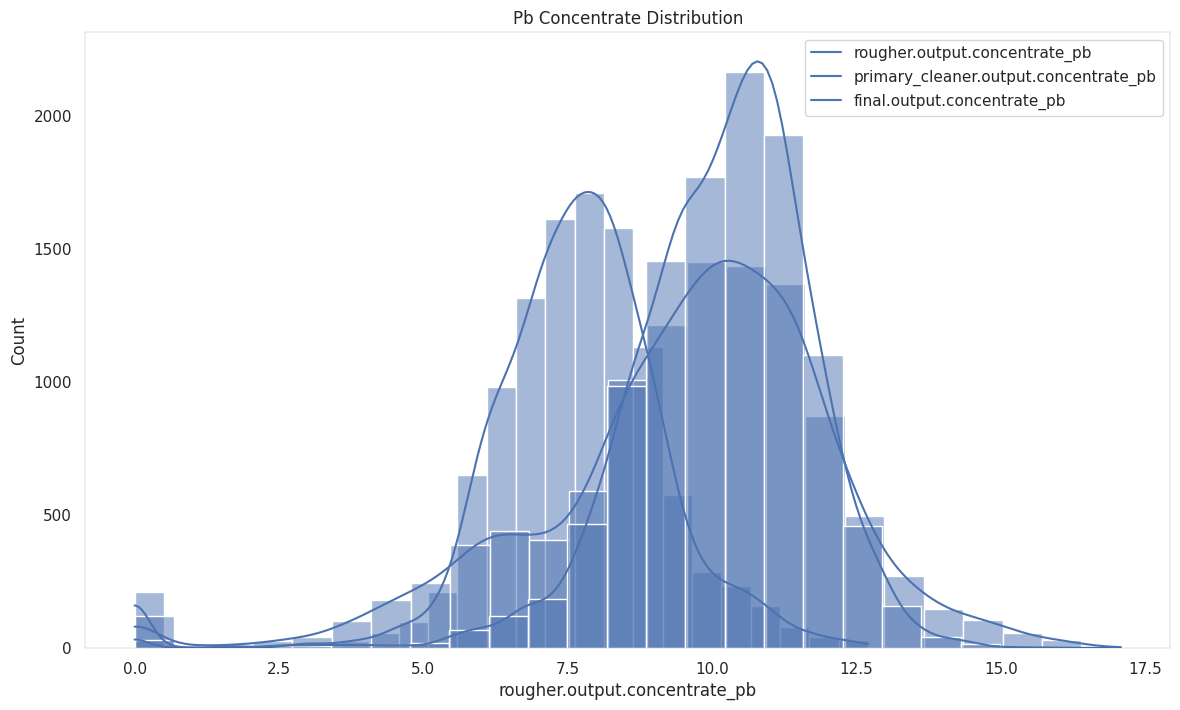

In [31]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(14, 8))
pb_values = [pb_metal, first_purif_pb,final_output_pb]
for r in pb_values:
    sns.histplot(r, bins=25, ax=ax, kde=True).set_title('Pb Concentrate Distribution')
    ax.legend(labels=['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb'])

In [32]:
# summary
print('Train dataset: \n',df_train['rougher.input.feed_size'].agg(['mean', 'median', 'var', 'std']))
print('')
print('Test dataset: \n',df_test['rougher.input.feed_size'].agg(['mean', 'median', 'var', 'std']))

Train dataset: 
 mean       57.215122
median     53.843214
var       357.739559
std        18.914004
Name: rougher.input.feed_size, dtype: float64

Test dataset: 
 mean       55.937535
median     50.002004
var       516.391711
std        22.724254
Name: rougher.input.feed_size, dtype: float64


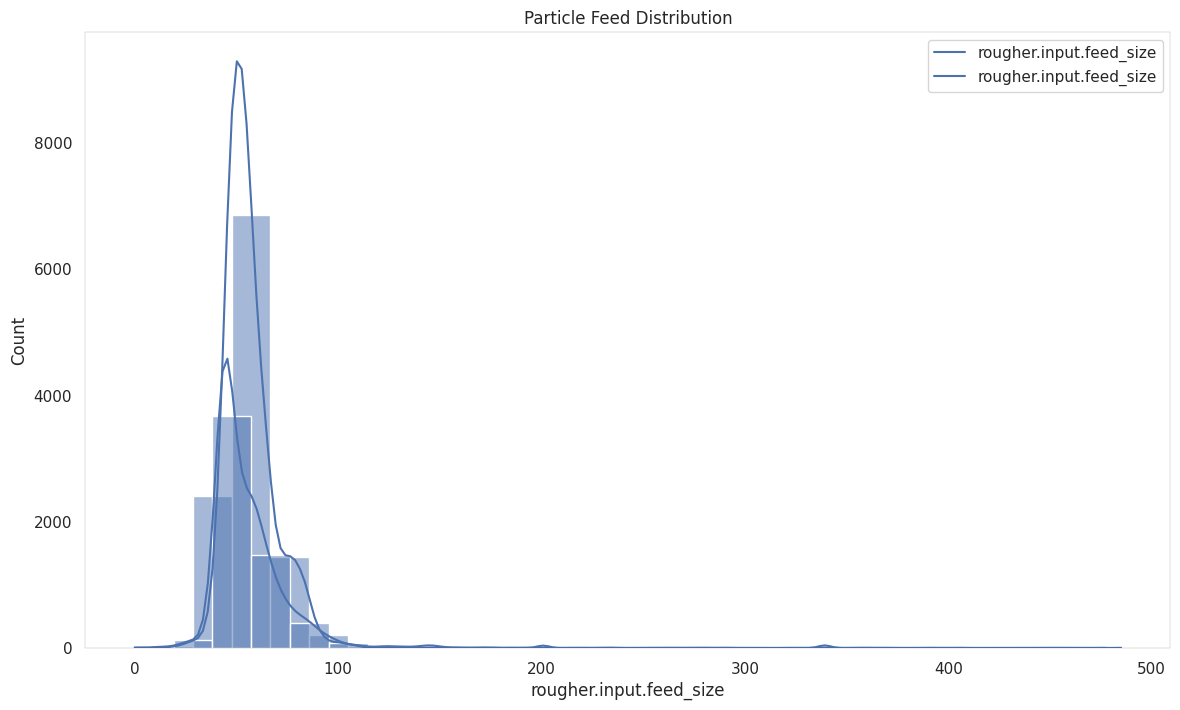

In [33]:
train_feed = df_train['rougher.input.feed_size']
test_feed = df_test['rougher.input.feed_size']

sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(14, 8))
feed_values = [train_feed, test_feed]
for r in feed_values:
    sns.histplot(r, bins=25, ax=ax, kde=True).set_title('Particle Feed Distribution')
    ax.legend(labels=['rougher.input.feed_size','rougher.input.feed_size'])

In [34]:
# summary
raw_feed = df_train[['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb']].sum(axis=1)
rougher_concentrate = df_train[['rougher.output.concentrate_au','rougher.output.concentrate_ag','rougher.output.concentrate_pb']].sum(axis=1)
final_concentrate = df_train[['final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb']].sum(axis=1).dropna()

print('\033[1mRaw Feed:\033[0m \n', raw_feed.agg(['mean', 'median', 'var', 'std']))
print('')
print('\033[1mRougher Concentrate:\033[0m \n', rougher_concentrate.agg(['mean', 'median', 'var', 'std']))
print('')
print('\033[1mFinal Concentrate:\033[0m \n', final_concentrate.agg(['mean', 'median', 'var', 'std']))

Raw Feed: 
 mean      20.436083
median    19.597006
var       18.577679
std        4.310183
dtype: float64

Rougher Concentrate: 
 mean      39.231118
median    40.049979
var       43.990866
std        6.632561
dtype: float64

Final Concentrate: 
 mean      59.460725
median    60.159669
var       22.211627
std        4.712921
dtype: float64


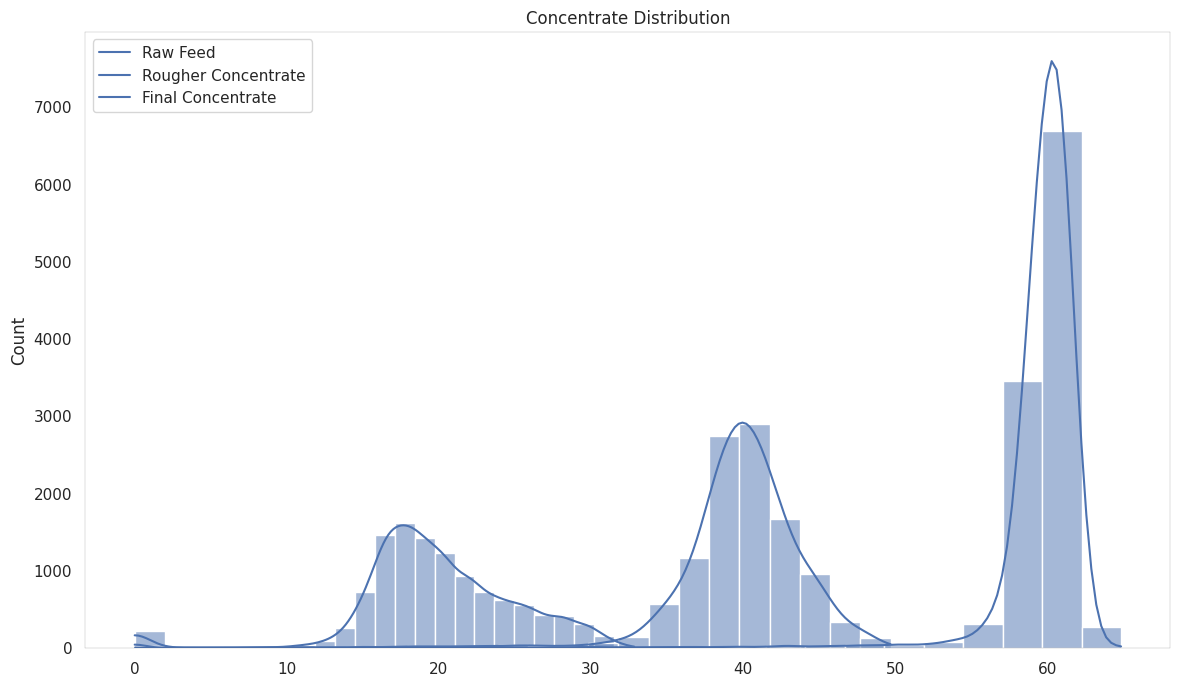

In [35]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(14, 8))
feed_values = [raw_feed, rougher_concentrate, final_concentrate]
for r in feed_values:
    sns.histplot(r, bins=25, ax=ax, kde=True).set_title('Concentrate Distribution')
    ax.legend(labels=['Raw Feed','Rougher Concentrate','Final Concentrate'])

<b> Findings </b>

<b> Individual Concentrates </b>

The concentrate distribution varies across Au, Ag, and Pb.

Au (gold) has a higher frequency of instances overall and its values are larger with Base concentration in the 15-25 range, followed by First Purification in the 30-40 range then 40+ under the Final Output stage. The feature variance increases as the material is purified and converted into the Final Output (very acute compression at that stage) which in turn is showing us more final output concentration out of this metal.

Ag (silver) concentrate shows a path reversal along with much smaller values overall (and less instances). As this material goes through its process towards the Final Output, we see a shift towards the left (less frequency in both values and instances compared to the First Purification and Base stages). Telling us that there is more difficulty refining/extracting this metal compared to gold.

Pb's (lead) concentration is much more centered compared to the other two, where we see Base concentrate spead over a 'longer' path as it passes through the First Purification stage then it 'shrinks' as it goes through its Final Output stage. Sitting in the middle of the pack and giving us a sense that this metal does just okay as it passes through the process.

Total Concentrates - Raw Feed, Rougher and Final

Overall concentrate distribution follows a positive path towards its final output (good extraction overall from feed, all the way to the final output).

As raw feed is introduced into the flotation process, we see a slightly higher rougher concentrate count as the metal is stabilized and 'concentrated'.

Once the raw feed is stabilized and is now a rougher concentrate, it enters the purification stages (two) where we see the final output being about double the amount from rougher to final.

Particle Feed

Feed distribution across the Training and Test datasets are similar.

We see higher frequency of values in the Test dataset which is expected given the preprocessing we did with the Train dataset (removal of NaNs, replacement, etc...).

Both follow the same path, positive skews. Mean is higher than the median in both instances.

Anomalies: performed in earlier stages for Training dataset (NaN removal, 0 fills and Infinity value replacement)

The concentrate distribution across Au, Ag, and Pb originally showed 'outliers' where values ranging from 0 to 1, NaN or Inf values took a decent 'bite' out of the dataset, after corrections on these, all the charts above have diminished values closely 'glued' to the y-axis without affecting the overall analysis.

Removing these 'anomalies' helps the modeling process so the model itself can 'focus' on the more recurring and significant values across the metals/stages.


<b> Final sMAPE Calculation </b>

In [36]:
rougher_target = pd.Series(df_train['rougher.output.recovery'])
final_target = pd.Series(df_train['final.output.recovery'])

rougher_predict = pd.Series(estimated_recovery, name='estimated_recovery')
final_predict = pd.Series(final_estimated_recovery, name='final_estimated_recovery')

target = pd.concat([rougher_target, final_target], axis=1).to_numpy()
prediction = pd.concat([rougher_predict, final_predict], axis=1).to_numpy()

In [37]:
def sMAPE_final_calc(target, prediction):
    """Function that follows our sMAPE calculation.
    Similar to MAE, but is expressed in relative values instead of absolute ones.
    It equally takes into account the scale of both the target and the prediction.
    """
    target = np.array(target)
    prediction = np.array(prediction)
    
    RT, FT = target[:, 0], target[:, 1]
    RP, FP = prediction[:, 0], prediction[:, 1]
    
    # creating the calculations for both the rougher and final recovery values
    rougher = 100/len(RT) * np.nansum(2 * np.abs(RP - RT) / (np.abs(RT) + np.abs(RP))) # + np.finfo(float).eps
    final = 100/len(FT) * np.nansum(2 * np.abs(FP - FT) / (np.abs(FT) + np.abs(FP))) # + np.finfo(float).eps
    final_sMAPE =  .25 * rougher + .75 * final
    
    return final_sMAPE

sMAPE_scorer = make_scorer(sMAPE_final_calc, greater_is_better=False)

In [38]:
np.seterr(invalid='ignore')
result = sMAPE_final_calc(target, prediction)
print('Final sMAPE:', result)

Final sMAPE: 1.2182257663447701e-14


<b> Modeling </b>

<b> Reproducibility </b>

In [39]:
seed = 12345

In [40]:
cv = RepeatedKFold(n_repeats=3, n_splits=3, random_state=seed)

<b> Training Data </b>

In [41]:
# creating the features and target variables from our Training set
target = df_train[['rougher.output.recovery','final.output.recovery']] # extracting target
features = df_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1) # feature extraction
features_net = df_train.drop(column_difference, axis=1) # net differences between Train and Test set

# constant model for in case there is a need for comparison
constant = pd.Series(target.mean(), index = target.index)

# scaled Training set to scale and take into account outliers in our data
scaler = RobustScaler(unit_variance=True)
features_net_scaled = scaler.fit_transform(features_net)

In [42]:
# initializing the models we will be iterating through
dm = DummyRegressor()
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=seed)
ridge = Ridge()
lasso = Lasso()
rf = RandomForestRegressor(random_state=seed)
multi_out = MultiOutputRegressor(rf)

regressors = [('DummyRegressor', dm),('LinearRegression', lr),
               ('Ridge', ridge), ('Lasso', lasso),
              ('DecisionTreeRegressor', dt), ('RandomForestRegressor', rf),
              ('MultiOutputRegressor', multi_out)]

In [43]:
for clf_name, clf in regressors:
    """Iterates through the regressors we initialized, takes into account the Name and Model we have provided.
    Fits each model and provides scoring metrics through cross_val_score and our sMAPE_scorer.
    The iteration is meant to provide us with baseline comparisons in order to select a model and then further tune via hyperparameter tuning/GridSearch.
    """
    # fit
    clf.fit(features_net_scaled, target)

    # label prediction
    # y_pred = clf.predict()

    # evaluations
    scoring = cross_val_score(clf, features_net_scaled, target, scoring=sMAPE_scorer, cv=cv)
    print('')
    print('{:s} Avg. sMAPE Cross-Val Score: {:.3f}'.format(clf_name, np.abs(scoring.mean())))


DummyRegressor Avg. sMAPE Cross-Val Score: 9.888

LinearRegression Avg. sMAPE Cross-Val Score: 7.833

Ridge Avg. sMAPE Cross-Val Score: 7.833

Lasso Avg. sMAPE Cross-Val Score: 8.403

DecisionTreeRegressor Avg. sMAPE Cross-Val Score: 7.860

RandomForestRegressor Avg. sMAPE Cross-Val Score: 5.919

MultiOutputRegressor Avg. sMAPE Cross-Val Score: 5.953


<b> Model Selection </b>

In [44]:
%%time
model = RandomForestRegressor(random_state=seed)
model_params = [{'max_depth': list(range(5, 11)), 'max_features': list(range(3,7)), 'n_estimators':[100, 150, 300]}]

cv_search = GridSearchCV(model, model_params, cv=cv, scoring=sMAPE_scorer)
cv_search.fit(features_net_scaled, target)
"""
features_net takes into account the differences in columns between our train and test sets
target is our target from the df_train set
"""
best_parameters = cv_search.best_params_
best_score = cv_search.best_score_

CPU times: user 27min 33s, sys: 759 ms, total: 27min 33s
Wall time: 27min 34s


In [45]:
print('Best Params: {},\n Best sMAPE Score: {:.3f}'.format(best_parameters, np.abs(best_score)))

Best Params: {'max_depth': 10, 'max_features': 6, 'n_estimators': 300},
 Best sMAPE Score: 6.659


In [ ]:
cv_results = pd.DataFrame(cv_search.cv_results_)

print('Average Fold Score:', np.mean(abs(cv_results['split0_test_score']) + abs(cv_results['split1_test_score'] +
                              abs(cv_results['split2_test_score'] + abs(cv_results['split3_test_score'])))))

In [ ]:
"""Our target is not included in our Test set (known discrepancy).
Pulling the target from the Full set.
"""
# we start with matching through our date columns
match_list = df_test['date'].to_list()
full_match_list = df_full['date'].to_list()
mask = df_full['date'].isin(match_list)
df_full.drop(columns='date', index=1, inplace=True)
matching_rows = df_full[mask].fillna(0)

# from our 'filter' we extract our target(s) and as a reminder, we are predicting two values in this project
test_target = matching_rows[['rougher.output.recovery','final.output.recovery']]
test_target = test_target[:-1] # kept getting a mismatch of one row, removed the last one

# further DF clean-up by removing our date feature as well as filling in any NaNs or Inf values
df_test.drop(columns='date', index=1, inplace=True)
df_test = df_test.fillna(0)
df_test.replace([np.inf, -np.inf], 0, inplace=True)

# features for our Test set is simply the Test set DF
features_test_scaled = scaler.transform(df_test)
# features_test = df_test

# since we have our features, we begin the prediction process on test data
y_pred_final = cv_search.predict(features_test_scaled)

# we utilize mean squared error metric in order to analyze performance
mse = mean_squared_error(test_target, y_pred_final)

# results, including our MSE and our RMSE in order to get a value that makes more sense 
print("RandomForestRegression Test dataset MSE:", mse)
print("RandomForestRegression Test dataset RMSE:", mse ** 0.5)
print('')

dummy_model = DummyRegressor().fit(features_net_scaled, target)
y_pred_dummy = dummy_model.predict(features_test_scaled)
dummy_mse = mean_squared_error(test_target, y_pred_dummy)

print("DummyRegression Test dataset MSE:", dummy_mse)
print("DummyRegression Test dataset RMSE:", dummy_mse ** 0.5)

In [ ]:
print('DummyRegressor Final sMAPE score (Test set) \n', sMAPE_final_calc(test_target,y_pred_dummy))
print('')
print('RandomForestRegressor Final sMAPE score (Test set) \n', sMAPE_final_calc(test_target,y_pred_final))
print('')

# sMAPE score function score based off of the Train set
y_train_pred_final = cv_search.predict(features_net_scaled)
print('RandomForestRegressor Final sMAPE score (Train set) \n', sMAPE_final_calc(target,y_train_pred_final))
print('')

<b> Conclusions </b>

We being our project by performing various checks on variability across the datasets as they were already split into a Full, Train and Test set.

Our analysis provides us with clues on missing values and potential outliers that will impact regression model performance. Variability is expected as the features include values from different points of the extraction process.

Clean-up is performed on the Train set to start (NaN removal), in order to get a truer sense on the various metals and their processes as missing values hinder our recovery/sMAPE calculations. Note: we created imputation and outlier removal cells in case these methods are needed and if they are truly impactful to our analysis/modeling. Imputing on NaN values negatively affects our modeling but the option is there.

Once we get a sense of distributions across metals, concentrates and feeds we head into modeling our data via utilization of 5+ regression models. This includes a DummyRegressor model for comparability and make sure there aren't any initial issues. RobustScaling is implemented to take into account outlier values (scaling that resists the pull of outliers).

We iterate through our regression models (without tuning) in order to cross-compare our cross_val scores which leverages our sMAPE_scorer function under the scoring parameter. This lets us have a baseline comparison to see how each model performs on the Train set before going further with hyperparameter tuning.
Our analysis shows us that the RandomForestRegressor is the better performing model across the regressors but comes at the cost of lower speed. Both LinerRegression and Ridge follow closely with slightly worse scores but at a much higher computation speed. Our base scores from cross_val were as follows:

    - Dummy: 9.88
    - Linear: 7.83
    - Ridge: 7.83
    - Lasso: 8.04
    - DecisionTree: 7.86
    - RandomForest: 5.91
    - MultiOutput: 5.95
Further analyzing the most optimal model, in this case the RandomForestRegressor, we perform final evaluations on our Test set and deploy hyperparameter tuning through GridSearchCV. The evaluation yields the scores below which perform better than our DummyRegressor.

    - MSE: 460
    - RMSE: 21

Our optimal model suggestion is based on our understanding that the company is placing more weight at the accuracy of the model compared to time/speed. RandomForestRegressor also gives added flexibility through more hyperparameter tuning than Linear or Ridge Regression (carefully calling out possible over-fitting nonetheless). If time/speed is desired, the recommendation is to use the Linear or Ridge regressors.

Based on the sMAPE_final_calc comparison between the RandomForestRegressor and the DummyRegressor model, we conclude that the RandomForestRegressor gives us a % error of ~25% when leveraging the Test set (compared to a nearly identical but slightly better result to our DummyRegressor model). This % error result from our RandomForestRegressor is still a more optimal result compared to all other models deployed.

When going one step further and analyzing the final sMAPE value on our train dataset, we find a ~6% error. Meaning our final sMAPE result on our Test set introduces a +19% delta to our overall results/predictions.